In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import plotly.express as px
from scipy.stats import shapiro, probplot
import pylab
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from pmdarima import auto_arima, autocorr_plot, ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox

---

# Read data

In [2]:
nintendo = pd.read_csv("../data/NTDOY-months.csv")
nintendo

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-31 00:00:00+00:00,3.388952,3.410762,3.357143,3.376952,3.376952,1.008429e+06
1,2014-02-28 00:00:00+00:00,2.975684,2.996316,2.963368,2.985579,2.985579,9.192632e+05
2,2014-03-31 00:00:00+00:00,2.952762,2.971143,2.941048,2.953143,2.953143,6.412381e+05
3,2014-04-30 00:00:00+00:00,2.748571,2.756190,2.730095,2.739905,2.739905,5.715476e+05
4,2014-05-31 00:00:00+00:00,2.732571,2.749524,2.720190,2.735048,2.735048,6.443095e+05
...,...,...,...,...,...,...,...
126,2024-07-31 00:00:00+00:00,13.701364,13.799546,13.620000,13.695909,13.695909,6.916227e+05
127,2024-08-31 00:00:00+00:00,13.338182,13.520455,13.232727,13.376818,13.376818,9.289773e+05
128,2024-09-30 00:00:00+00:00,13.446000,13.539000,13.319500,13.417500,13.417500,4.408050e+05
129,2024-10-31 00:00:00+00:00,13.261739,13.376522,13.130435,13.272609,13.272609,8.130043e+05


In [3]:
df = nintendo[["Date", "Adj Close"]]
df.set_index("Date", inplace=True)

In [4]:
px.line(data_frame=df, x=df.index, y=df["Adj Close"])

In [5]:
px.line(data_frame=df, x=df.index, y=df["Adj Close"].diff())

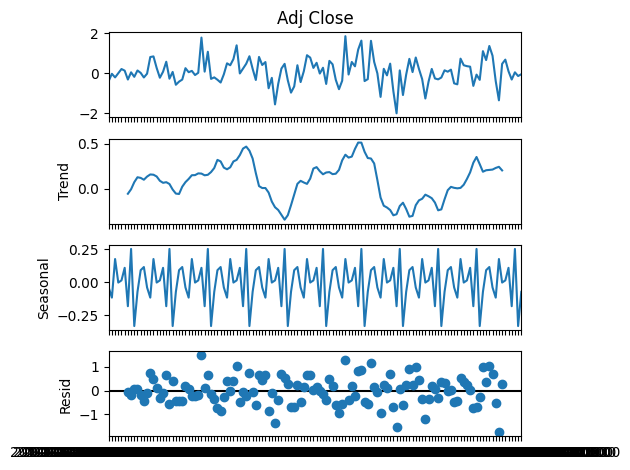

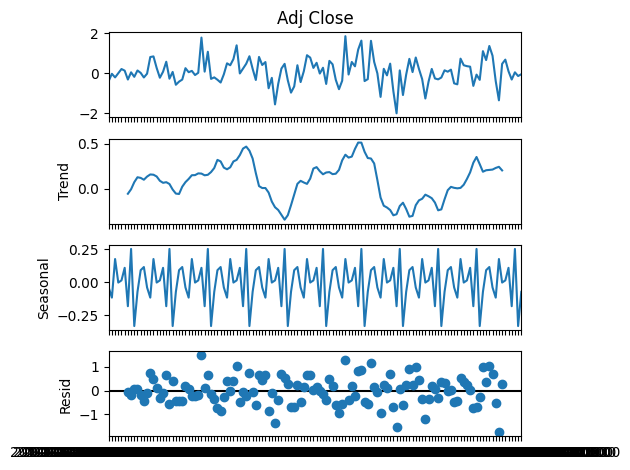

In [6]:
seasonal_decompose(df["Adj Close"].diff().dropna(), period=12).plot()

---

# Stationary check

In [7]:
def adf_test(series):
    res = adfuller(series, maxlag=int((len(df)-1)**(1/3)))
    return {
        "Statistic":res[0],
        "p-value":res[1],
    }

In [8]:
adf_test(df["Adj Close"])

{'Statistic': -1.4625477448036177, 'p-value': 0.5519504459964034}

### Check for stationary in log original dataset
- H0: Non stationary | H1: Stationary
<br/> p-value > 0.05 => H0 Correct

In [9]:
log_df = np.log(df["Adj Close"])

In [10]:
temp = px.line(data_frame=df, x=df.index, y=log_df)
temp

In [11]:
print(adf_test(np.log(df["Adj Close"])))

{'Statistic': -1.716751854574692, 'p-value': 0.42250274038145397}


### Check for stationary in diff log, copy last value of da series to prevent the mismatch data size

In [12]:
difflog = np.diff(np.log(df["Adj Close"]))
difflog = np.append(difflog, difflog[-1])

In [13]:
adf_test(difflog)

{'Statistic': -9.224984957290435, 'p-value': 1.7389089841659996e-15}

In [14]:
temp = px.line(data_frame=difflog, x=df.index, y=difflog)
temp

---

# Check for normality

In [15]:
def shapiro_test(series):
    res = shapiro(series)
    return {
        "statistic":res[0],
        "p-value":res[1]
    }

In [16]:
shapiro_test(np.diff(df["Adj Close"]))

{'statistic': 0.9792935252189636, 'p-value': 0.0442114919424057}

In [17]:
shapiro_test(difflog)

{'statistic': 0.9356715679168701, 'p-value': 9.74412432697136e-06}

- compare diff df to norm dist

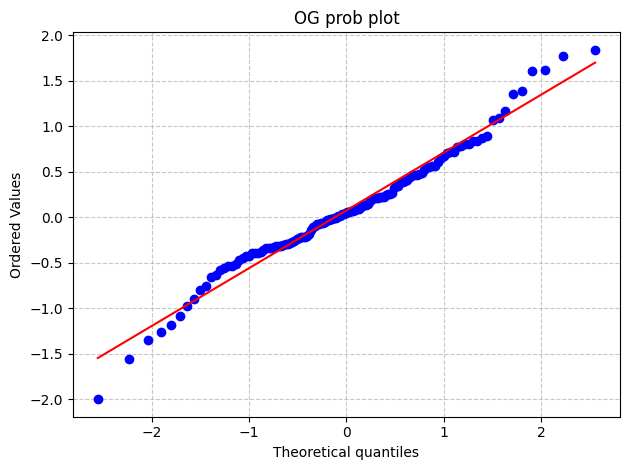

In [18]:
probplot1 = probplot(np.diff(df["Adj Close"]), dist="norm", plot=plt)
plt.grid(True, linestyle="--", alpha=0.7)
plt.title("OG prob plot")
plt.tight_layout()
plt.show()

- compare diff log to norm dist

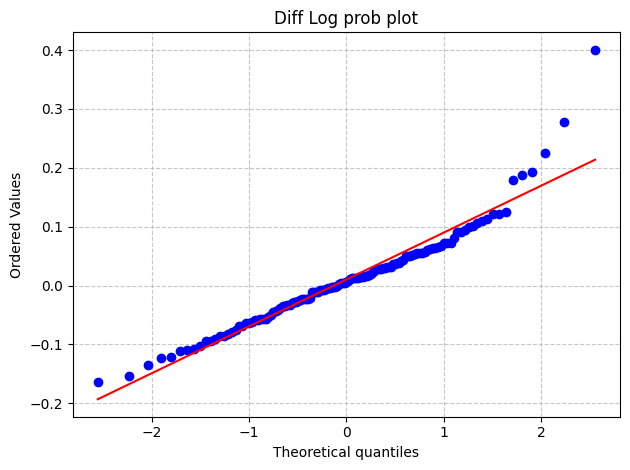

In [19]:
probplot2 = probplot(difflog, dist="norm", plot=plt)

plt.grid(True, linestyle="--", alpha=0.7)
plt.title("Diff Log prob plot")
plt.tight_layout()
plt.show()

---

# ACF and PACF

In [20]:
def plot_acf2(series):
    fig, axes = plt.subplots(ncols=1, nrows=2)
    plot_acf(series, marker="", ax=axes[0], zero=False)
    plot_pacf(series, marker="", ax=axes[1], zero=False)

    axes[0].grid(True, linestyle="--", alpha=0.7)
    axes[1].grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    axes[0].set_xticks(range(0, 25))
    axes[1].set_xticks(range(0, 25))
    plt.show()

    

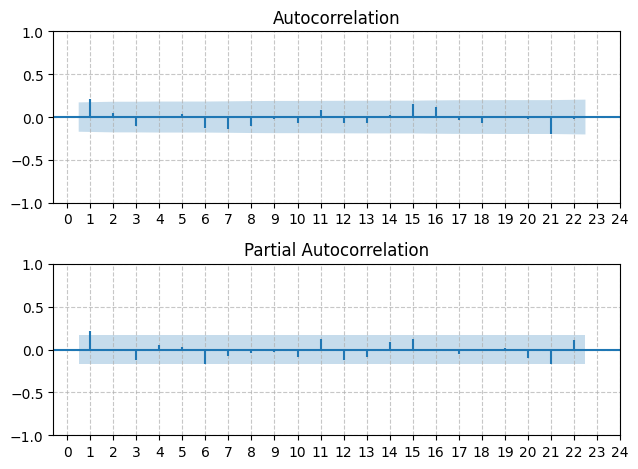

In [21]:
plot_acf2(difflog)

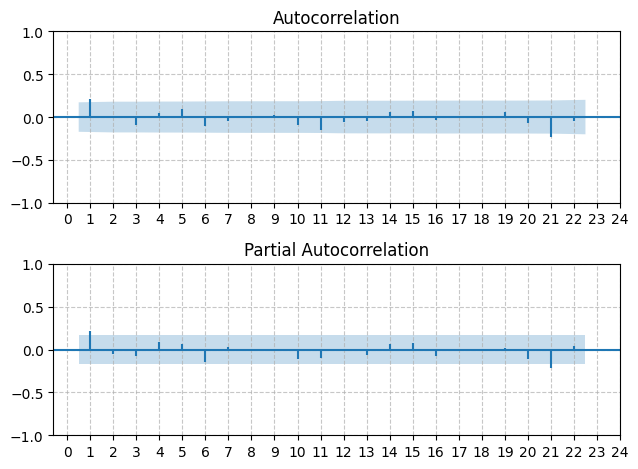

In [22]:
plot_acf2(np.diff(df["Adj Close"]))

---

# Models

### Train test split in time series way

In [69]:
train_size = int(df.shape[0] * 0.96)  # Use 80% of data for training
train, test = df.iloc[:train_size], df.iloc[train_size:]

log_train = np.log(train["Adj Close"])
diff_log_train = np.diff(np.log(train["Adj Close"]))
diff_log_train = np.append(diff_log_train, diff_log_train[-1])

### AR, MA, ARMA, ARIMA

- Auto Arima for log original data

In [70]:
arima1 = auto_arima(diff_log_train, seasonal=False)
arima1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 141.496
Date:                Tue, 19 Nov 2024   AIC                           -272.992
Time:                        08:28:29   BIC                           -258.850
Sample:                             0   HQIC                          -267.247
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2366      0.083     -2.866      0.004      -0.398      -0.075
ar.L2         -0.7978      0.078    -10.170      0.000      -0.952      -0.644
ma.L1          0.4361      0.053      8.307      0.000       0.333       0.539
ma.L2          0.9634      0.082     11.764      0.000       0.803       1.124
sigma2         0.0060      0.001      9.329      0.000       0.005       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                53.36
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
arima1_log_diff_preds = arima1.predict(n_periods=test.shape[0])
# arima1_log_diff_preds = np.exp(preds)
ARIMA1_reverted_log_predictions = [np.log(test["Adj Close"]).to_numpy()[-1] + arima1_log_diff_preds[0]]
for i in range(1, len(arima1_log_diff_preds)):
    ARIMA1_reverted_log_predictions.append(ARIMA1_reverted_log_predictions[-1] + arima1_log_diff_preds[i])
arima1_preds = np.exp(ARIMA1_reverted_log_predictions)

np.sqrt(mean_squared_error(test, arima1_preds))


0.17673091430080903

=> MSE: 0.221

Check if residual is similar to white fucking noise

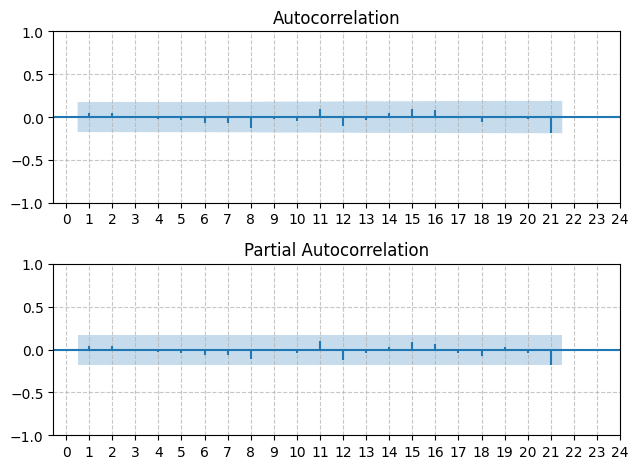

In [72]:
arima1_resid = arima1.resid()
plot_acf2(arima1_resid)

In [73]:
acorr_ljungbox(arima1_resid**2)
# arima1_resid

,lb_stat,lb_pvalue
1,0.041919,0.837775
2,1.934396,0.380147
3,3.124103,0.372884
4,3.669363,0.452598
5,3.716484,0.590913
6,4.129665,0.659134
7,5.091982,0.648739
8,6.105084,0.635462
9,7.122714,0.624345
10,7.326671,0.694287


=> No line exceed the blue area => Its white noise => Model is gud

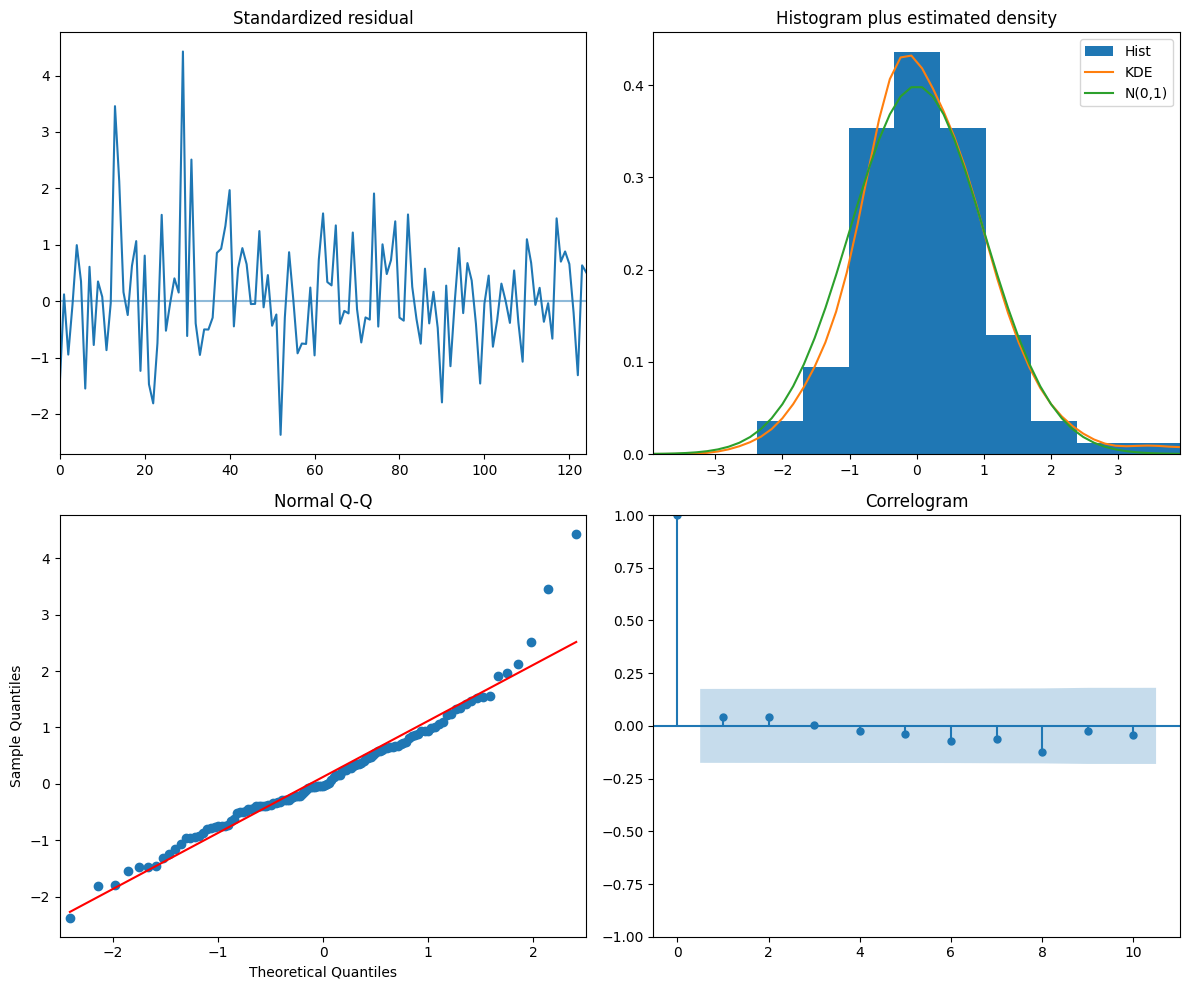

In [74]:
arima1.plot_diagnostics(figsize=(12, 10))

plt.tight_layout()
plt.show()

- Auto arima for original data

In [75]:
arima2 = auto_arima(train["Adj Close"], seasonal=False)
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -115.188
Date:                Tue, 19 Nov 2024   AIC                            240.376
Time:                        08:28:33   BIC                            254.477
Sample:                    01-31-2014   HQIC                           246.104
                         - 05-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2423      0.094     -2.566      0.010      -0.427      -0.057
ar.L2         -0.7752      0.093     -8.329      0.000      -0.958      -0.593
ma.L1          0.4375      0.051      8.639      0.000       0.338       0.537
ma.L2          0.9225      0.064     14.527      0.000       0.798       1.047
sigma2         0.3718      0.041      9.077      0.000       0.292       0.452
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 5.84
Prob(Q):                              0.68   Prob(JB):                         0.05
Heteroskedasticity (H):               1.96   Skew:                             0.02
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
arima2_preds = arima2.predict(n_periods=test.shape[0])
np.sqrt(mean_squared_error(test, arima2_preds))
# preds

0.34536857229370665

=> MSE: 0.118

Check if residual is similar to white fucking noise

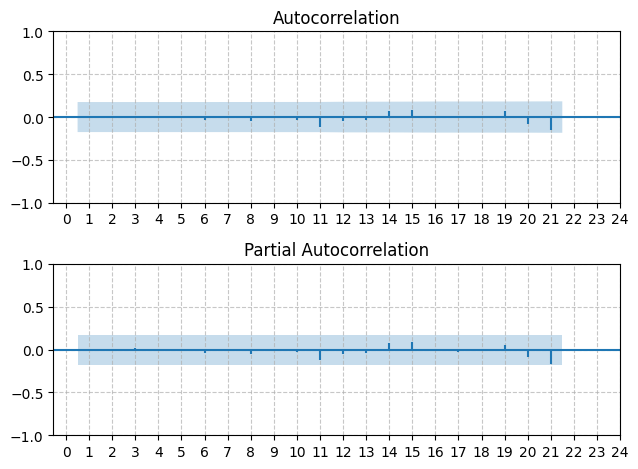

In [77]:
arima2_resid = arima2.resid()
plot_acf2(arima2_resid)

=> No line exceed the fucking blue area => Its white noise => Model is gud

In [109]:
def jungkook_test_sq(series):
    res = acorr_ljungbox(series**2).iloc[:,1]
    signf_lag = np.where(res < 0.05)[0]
    if (len(signf_lag)>0):
        print("Not guarantee to be white noise")
    else:
        print("Guarantee to be white noise")

    return res

In [110]:
jungkook_test_sq(arima1_resid)

Guarantee to be white noise


1     0.837775
2     0.380147
3     0.372884
4     0.452598
5     0.590913
6     0.659134
7     0.648739
8     0.635462
9     0.624345
10    0.694287
Name: lb_pvalue, dtype: float64

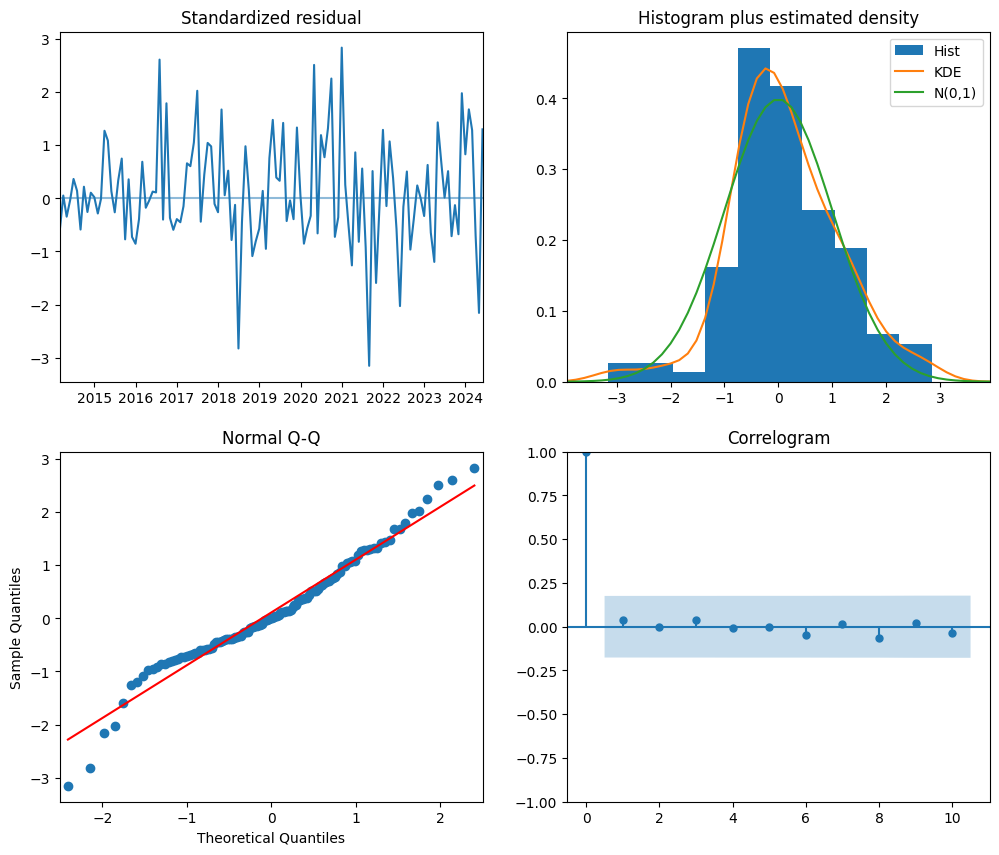

In [79]:
arima2.plot_diagnostics(figsize=(12, 10))
plt.show()

- AR(1)

In [80]:
AR1 = ARIMA(order=(1, 0, 0)).fit(diff_log_train)
AR1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 136.587
Date:                Tue, 19 Nov 2024   AIC                           -267.174
Time:                        08:28:34   BIC                           -258.689
Sample:                             0   HQIC                          -263.727
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0085      0.008      1.020      0.308      -0.008       0.025
ar.L1          0.2138      0.093      2.308      0.021       0.032       0.395
sigma2         0.0066      0.001     11.889      0.000       0.005       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               106.33
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
AR1_log_diff_preds = AR1.predict(n_periods=test.shape[0])
AR1_reverted_log_predictions = [np.log(test["Adj Close"]).to_numpy()[-1] + AR1_log_diff_preds[0]]
for i in range(1, len(AR1_log_diff_preds)):
    AR1_reverted_log_predictions.append(AR1_reverted_log_predictions[-1] + AR1_log_diff_preds[i])

AR1_reverted_preds = np.exp(AR1_reverted_log_predictions)
np.sqrt(mean_squared_error(test, AR1_reverted_preds))

0.5734706065360686

=> MSE: 0.57

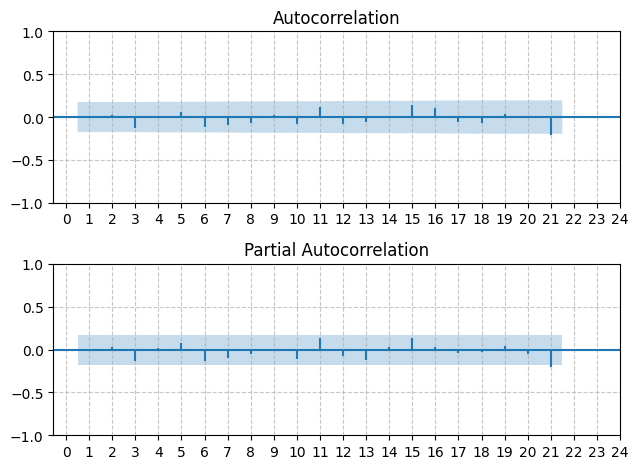

In [115]:
AR1_resid = AR1.resid()
plot_acf2(AR1_resid)

In [111]:
jungkook_test_sq(AR1_resid)

Guarantee to be white noise


1     0.896600
2     0.664019
3     0.812402
4     0.768888
5     0.864159
6     0.928935
7     0.964828
8     0.857166
9     0.892417
10    0.927229
Name: lb_pvalue, dtype: float64

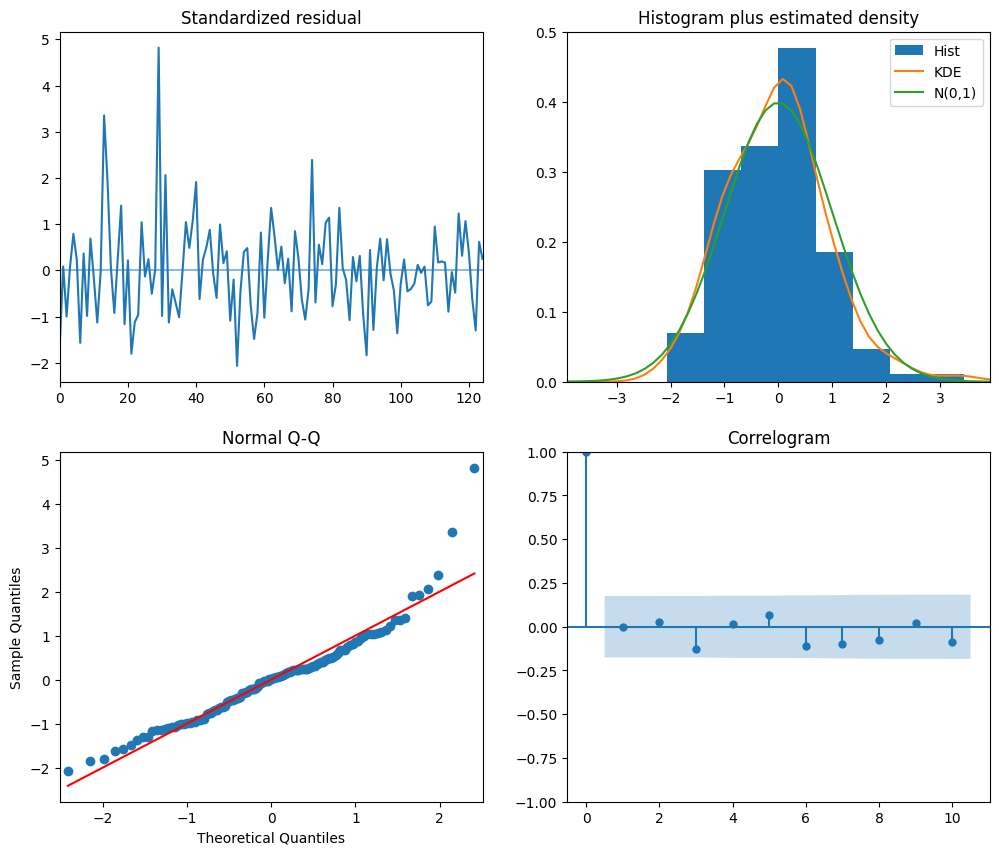

In [116]:
AR1.plot_diagnostics(figsize=(12, 10))
plt.show()

- ARMA(1, 1)

In [84]:
ARMA1 = ARIMA(order=(1, 0, 1)).fit(diff_log_train)
ARMA1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 136.587
Date:                Tue, 19 Nov 2024   AIC                           -265.174
Time:                        08:28:35   BIC                           -253.861
Sample:                             0   HQIC                          -260.578
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0085      0.009      0.956      0.339      -0.009       0.026
ar.L1          0.2166      0.352      0.615      0.539      -0.474       0.907
ma.L1         -0.0029      0.356     -0.008      0.993      -0.701       0.695
sigma2         0.0066      0.001     11.808      0.000       0.005       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               106.39
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
ARMA1_log_diff_preds = ARMA1.predict(n_periods=test.shape[0])
ARMA1_reverted_log_predictions = [np.log(test["Adj Close"]).to_numpy()[-1] + ARMA1_log_diff_preds[0]]
for i in range(1, len(ARMA1_log_diff_preds)):
    ARMA1_reverted_log_predictions.append(ARMA1_reverted_log_predictions[-1] + ARMA1_log_diff_preds[i])

ARMA1_reverted_preds = np.exp(ARMA1_reverted_log_predictions)
np.sqrt(mean_squared_error(test, ARMA1_reverted_preds))

0.5738209816942956

=> MSE: 0.57

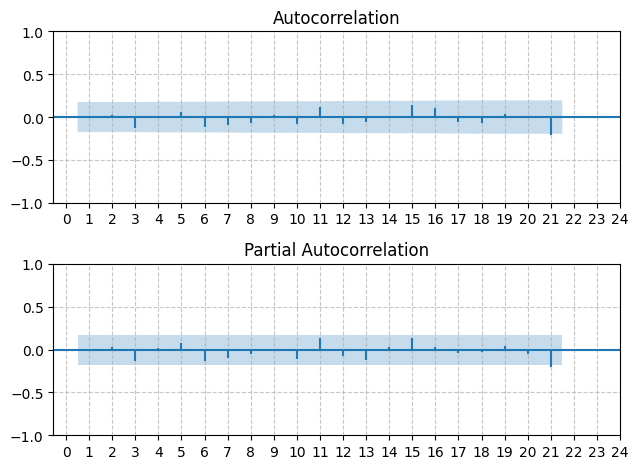

In [86]:
ARMA1_resid = ARMA1.resid()
plot_acf2(AR1_resid)

In [117]:
jungkook_test_sq(ARMA1_resid)

Guarantee to be white noise


1     0.896373
2     0.666520
3     0.814309
4     0.770451
5     0.865237
6     0.929622
7     0.965239
8     0.858070
9     0.893090
10    0.927785
Name: lb_pvalue, dtype: float64

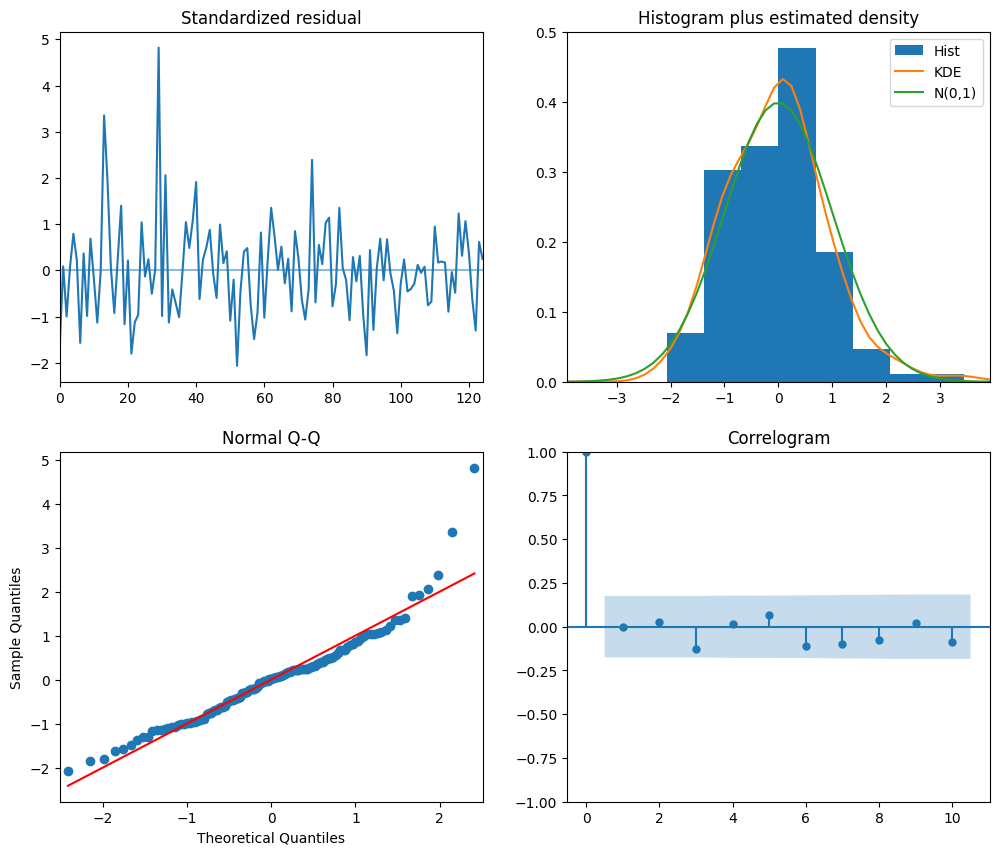

In [118]:
ARMA1.plot_diagnostics(figsize=(12, 10));

In [88]:
MA1 = ARIMA(order=(0, 0, 1)).fit(diff_log_train)
MA1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 136.337
Date:                Tue, 19 Nov 2024   AIC                           -266.674
Time:                        08:28:35   BIC                           -258.190
Sample:                             0   HQIC                          -263.227
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0108      0.010      1.104      0.270      -0.008       0.030
ma.L1          0.1923      0.089      2.150      0.032       0.017       0.368
sigma2         0.0066      0.001     11.791      0.000       0.006       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               101.20
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [121]:
MA1_log_diff_preds = MA1.predict(n_periods=test.shape[0])
MA1_reverted_log_predictions = [np.log(test["Adj Close"]).to_numpy()[-1] + MA1_log_diff_preds[0]]
for i in range(1, len(MA1_log_diff_preds)):
    MA1_reverted_log_predictions.append(MA1_reverted_log_predictions[-1] + MA1_log_diff_preds[i])

MA1_reverted_preds = np.exp(MA1_reverted_log_predictions)
np.sqrt(mean_squared_error(test, MA1_reverted_preds))


0.5405256516354698

In [120]:
jungkook_test_sq(MA1.resid())

Guarantee to be white noise


1     0.868128
2     0.510914
3     0.678366
4     0.660519
5     0.782969
6     0.873195
7     0.929439
8     0.783236
9     0.837500
10    0.882066
Name: lb_pvalue, dtype: float64

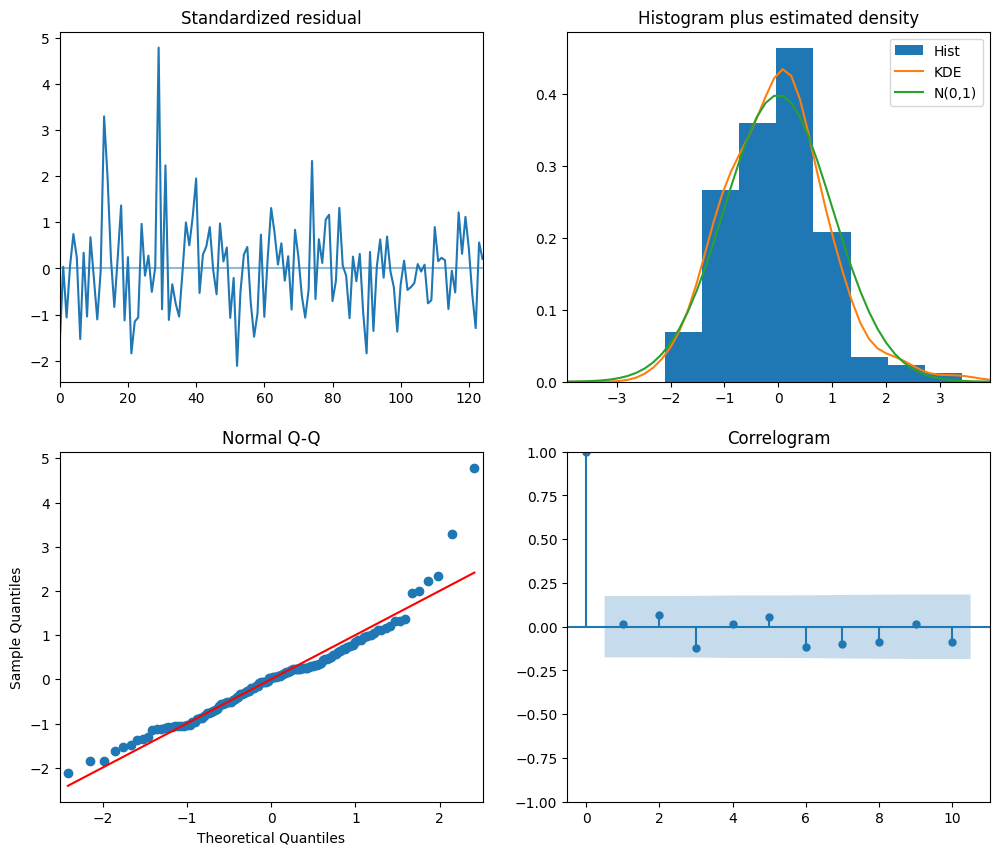

In [119]:
MA1.plot_diagnostics(figsize=(12, 10));

# Forecast

- Rolling forecast

In [90]:
# Initialize variables
history = list(log_train)  # Start with the training data
predictions = []  # To store rolling predictions

rolling_tests = np.log(df.iloc[-30:])["Adj Close"]

# Rolling forecast
for t in range(rolling_tests.shape[0]):
    # Fit the ARIMA model on the available history
    model = ARIMA(order=(2,1,2)).fit(history)
    
    # Predict the next value
    forecast_preds = model.predict(n_periods=1)[0]

    predictions.append(forecast_preds)
    
    # Add the actual value from the test set to the history for the next iteration
    history.append(rolling_tests.iloc[t])

# Calculate the mean squared error for the rolling forecast
rolling_mse = mean_squared_error(rolling_tests, predictions)

print(f"Rolling Forecast MSE: {rolling_mse}")




c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Admin\AppDa

Rolling Forecast MSE: 0.003767010940819532


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [91]:
forecast_index = pd.date_range(start=test.index[0], periods=len(test), freq='M')

In [122]:

trace_riu = go.Scatter(
    x=df.index,
    y=df["Adj Close"],
    mode="lines+markers",
    line=dict(color="blue"),
    name="Riu"
)

ARIMA1_forecast = go.Scatter(
    x=forecast_index,
    y=arima1_preds,
    line=dict(color='orange', dash='dash'),
    mode="lines+markers",
    marker=dict(symbol='circle', size=4),
    name=f"ARIMA{arima1.order} forecast"
)

ARIMA2_forecast = go.Scatter(
    x=forecast_index,
    y=arima2_preds,
    line=dict(color='green', dash='dash'),
    mode="lines+markers",
    marker=dict(symbol='circle', size=4),
    name=f"ARIMA{arima2.order} forecast"
)

# AR1_forecast = go.Scatter(
#     x=forecast_index,
#     y=AR1_reverted_preds,
#     line=dict(color='green', dash='dash'),
#     mode="lines+markers",
#     marker=dict(symbol='circle', size=4),
#     name=f"AR({AR1.order[0]}) forecast"

# )

ARMA1_forecast = go.Scatter(
    x=forecast_index,
    y=AR1_reverted_preds,
    line=dict(color='purple', dash='dash'),
    mode="lines+markers",
    marker=dict(symbol='circle', size=4),
    name=f"ARMA{ARMA1.order[0] , ARMA1.order[2]} forecast"

)


rolling_forecast = go.Scatter(
    x=rolling_tests.index,
    y=np.exp(predictions),
    line=dict(color='red', dash='dash'),
    mode="lines+markers",
    marker=dict(symbol='circle', size=4),
    name="rolling forecast"
)



layout = go.Layout(
    title="Riu vs Forecasted Data",
    xaxis=dict(title="Time"),
    yaxis=dict(title="Value"),
    showlegend=True, 
)



fig = go.Figure(data=[trace_riu, ARIMA1_forecast, ARIMA2_forecast, ARMA1_forecast, rolling_forecast])
fig.show()

In [93]:
fig.write_html("forecasts.html")